In [1]:
%matplotlib inline
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.special import expi, exp1

** Define constants **

In [7]:
hbar=6.626e-34/2/np.pi
e = 1.6e-19
eo = 8.85e-12;
m = 9.1e-31;
me1 = 0.16;   # CdSe me=0.13 mh=0.45       # CdS me:0.21 mh:0.8
mh1 = 0.57;    # CdTe me=0.1  mh=0.4
me2 = 0.16;   
mh2 = 0.57;
er1 = 9.2;           # CdSe: 9.3(WZ) 10.2(ZB)        # CdTe: 10.2(ZB)
er2 = 8.6;           # CdS: 8.9 or 7 or 6.3
Eg = 2.02;             # ZnSe: me0.14 mh0.53 Eg2.72   CBO=0.8   qX:4.09 er=9.2
Ep = 23                     # CdS: me.18 mh0.6 Eg2.45       VBO=0.52    qX=4.79 er=8.6
Cbo = 0.7;           # CdSe qX: 4.95     Eg: 1.75 er=9.5
Vbo = 0.43;             # CdTe qX: 4.1     Eg: 1.8
k = np.sqrt(Ep/2);           # K dot P matrix element
delta = 1e-15;              # use for avoid divergence in V(q)
hole_barrier = 1  

** Define Geometry**

In [16]:
Qw = 5e-9
L = Qw + 2e-9       # Sim. length L >> QW (confined area)
space = 1e-10;
X = np.linspace(-L , L, 2*L/space+1)
n = X.size
region = [-L,-Qw,0,Qw,L]
indx = np.zeros(len(region))
for var in range(len(region)):
    indx[var]=(region[var]-region[0])/space

CB_value=[4.09,0.8,0,4.09]  #'buffer' to insert buffer
VB_value=[0.52,0,0.52,0.52]
er_value=[er1,er1,er2,er2]
me_value=[me1,me1,me2,me2]
mh_value=[mh1,mh1,mh2,mh2]

In [17]:
import piecewise2      #make a piecewise function with x as region, y as value
Cb=piecewise2.piecewise2(indx,CB_value)
Vb=piecewise2.piecewise2(indx,VB_value)
er=piecewise2.piecewise2(indx,er_value)
me=piecewise2.piecewise2(indx,me_value)
mh=piecewise2.piecewise2(indx,mh_value)

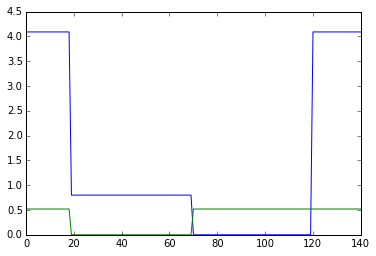

In [19]:
plt.plot(Cb)
plt.plot(Vb)

In [86]:
Vm = 0.04

In [87]:
Vm = Vm*L/Qw
PE = np.linspace(0,Vm,n)
PE = PE-(Vm/2)

Cb1 = Cb+Eg/2
Vb1 = Vb+Eg/2

Cb2 = Cb+PE+Eg/2
Vb2 = Vb-PE+Eg/2


#Define Hamiltonian cell
Ae = np.mat(np.zeros((n,n)))
Ah = np.mat(np.zeros((n,n)))
Apoisson = np.mat(np.zeros((n,n)))
Pe1 = np.diag(Cb1)
Ph1 = np.diag(Vb1)
Pe2 = np.diag(Cb2)
Ph2 = np.diag(Vb2)
off_diag = np.mat(np.zeros((n,n)))

Ae[0,0] = -(1/me[0]+1/me[1]);
Ae[1,0] = 1/me[0];
Ae[n-1,n-1] = -(1/me[n-2]+1/me[n-1]);
#Ae[n-1,n-2]=Ae[n-1,n-2]*2  % Dirichlet-Neumann boundary condition for 
Ae[n-2,n-1] = 1/me[n-1];

Ah[0,0] = -(1/mh[0]+1/mh[1]);
Ah[1,0] = 1/mh[0];
Ah[n-1,n-1] = -(1/mh[n-2]+1/mh[n-1]);
#Ah[n-1,n-2]=Ah[n-1,n-2]*2  % Dirichlet-Neumann boundary condition for 
Ah[n-2,n-1] = 1/mh[n-1];

Apoisson[0,0] = -(eo*er[0]+eo*er[1]);
Apoisson[1,0] = eo*er[0];
Apoisson[n-1,n-1] = -(eo*er[n-2]+eo*er[n-1]);
#Apoisson[n-1,n-2]=Apoisson[n-1,n-2]*2  % Dirichlet-Neumann boundary condition for 
Apoisson[n-2,n-1] = eo*er[n-1];

off_diag[0,1] = 1;
off_diag[1,0] = -1;
off_diag[n-1,n-2] = -1;
off_diag[n-2,n-1] = 1;

for i in range(1,n-1):
    Ae[i,i] = -(1/me[i-1]+1/me[i+1])
    Ah[i,i] = -(1/mh[i-1]+1/mh[i+1])
    Apoisson[i,i] = -(eo*er[i-1]+eo*er[i+1])
    Ae[i+1,i] = 1/me[i-1]
    Ah[i+1,i] = 1/mh[i-1]
    Apoisson[i+1,i] = eo*er[i-1]
    Ae[i-1,i] = 1/me[i+1]
    Ah[i-1,i] = 1/mh[i+1]
    Apoisson[i-1,i] = eo*er[i+1]
    off_diag[i,i+1] = 1
    off_diag[i+1,i] = -1

In [88]:
kp = np.zeros(shape=(2*n,2*n), dtype=complex)
kp[0:n, 0:n] = -Ae/m/e*(hbar**2)/2/(space**2) + Pe1
kp[n:2*n, n:2*n] = Ah/m/e*(hbar**2)/2/(space**2) - Ph1
kp[0:n, n:2*n] = off_diag*(-1j)*hbar*k/2/space
kp[n:2*n, 0:n] = kp[0:n, n:2*n]
Apoisson = Apoisson/(space**2);

In [89]:
ev, ef = np.linalg.eigh(kp)      #eigen value of Hermitian operator
Cb_temp = abs(ev-min(Cb))
Vb_temp = abs(ev+min(Vb))
Cb_E_address = np.where(Cb_temp==min(abs(Cb_temp)))
Vb_E_address = np.where(Vb_temp==min(abs(Vb_temp)))
Cb_energy = ev[Cb_E_address]
Vb_energy = ev[Vb_E_address]
Ee_address = Cb_E_address[0]
Eh_address = Vb_E_address[0]
Ee_address = int(Ee_address[0])
Eh_address = int(Eh_address[0])

In [90]:
psi_e = ef[0:n, n]  
psi_h = ef[n:2*n, n-1]
psi_e_sq = psi_e*np.conjugate(psi_e)   
psi_h_sq = psi_h*np.conjugate(psi_h)
norm_e = sum(psi_e_sq)*space
norm_h = sum(psi_h_sq)*space
psi_e_sq_norm = psi_e_sq/space
psi_h_sq_norm = psi_h_sq/space
psi_e_norm = psi_e/np.sqrt(norm_e)   #normalized wf
psi_h_norm = psi_h/np.sqrt(norm_h)

In [91]:
distance_lower = np.zeros((n,n))
for i in range(n):
    temp = np.eye(n,k=i)*i
    distance_lower = distance_lower+temp
distance_upper = distance_lower.T
distance = distance_lower+distance_upper
distance = distance+np.eye(n,k=0)
distance = 1/distance-np.eye(n,k=0)

del Cb_E_address, Vb_E_address
## self-consistency
old_Cb_E=0

[ 1.08451251]
[ 1.08425088]


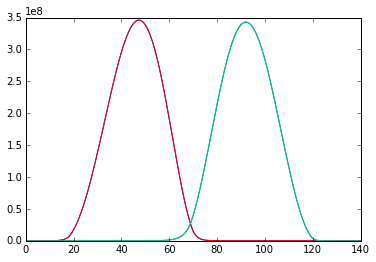

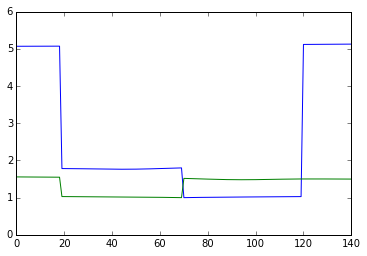

In [92]:
for i in range(30):
    Velectron = np.zeros((n))
    Vhole = np.zeros((n))
    e_over_r = np.zeros((n))
    h_over_r = np.zeros((n))
    for j in range(n):
        e_over_r = np.multiply(distance[j,:], np.real(psi_e_sq_norm))
        h_over_r = np.multiply(distance[j,:],np.real(psi_h_sq_norm))
        Velectron[j] = sum(e_over_r)/er[j]
        Vhole[j] = sum(h_over_r)/er[j]
    Velectron = Velectron*e/4/np.pi/eo/(er1+er2)*2
    Vhole = Vhole*e/4/np.pi/eo/(er1+er2)*2
    Velectron_mat = np.diag(Velectron)
    Vhole_mat = np.diag(Vhole)
    kkp = np.zeros(shape=(2*n,2*n), dtype=complex)
    kkp[0:n, 0:n] = -Ae/m/e*(hbar**2)/2/(space**2) + Pe2 - Vhole_mat
    kkp[n:2*n, n:2*n] = Ah/m/e*(hbar**2)/2/(space**2) - Ph2 + Velectron_mat
    kkp[0:n, n:2*n] = off_diag*(-1j)*hbar*k/2/space
    kkp[n:2*n, 0:n] = kkp[0:n, n:2*n]

    #kkp[0:n, 0:n]=kp[0:n, 0:n]-Vhole_mat
    #kkp[n:2*n, n:2*n]= kp[n:2*n, n:2*n]+Velectron_mat

    ev, ef = np.linalg.eigh(kkp)      #eigen value of Hermitian operator
    Cb3 = Cb2-Vhole
    Vb3 = Vb2-Velectron
    Cb_temp = abs(ev-min(Cb3))
    Vb_temp = abs(ev+min(Vb3))
    Cb_E_address = np.where(Cb_temp==min(abs(Cb_temp)))
    Vb_E_address = np.where(Vb_temp==min(abs(Vb_temp)))

    Cb_energy = ev[Cb_E_address[0]]
    Vb_energy = ev[Vb_E_address[0]]
    #Ee_address=Cb_E_address[0]
    #Eh_address=Vb_E_address[0]
    #Ee_address=float(Ee_address[0])
    #Eh_address=float(Eh_address[0])
    psi_e=ef[0:n, int(Cb_E_address[0])]  
    psi_h=ef[n:2*n, int(Vb_E_address[0])]

    psi_e_sq = psi_e*np.conjugate(psi_e)   
    psi_h_sq = psi_h*np.conjugate(psi_h)
    norm_e = sum(psi_e_sq)*space
    norm_h = sum(psi_h_sq)*space
    psi_e_sq_norm = psi_e_sq/space
    psi_h_sq_norm = psi_h_sq/space
    psi_e_norm = psi_e/np.sqrt(norm_e)   #normalized wf
    psi_h_norm = psi_h/np.sqrt(norm_h)
    print Cb_energy
    plt.figure(1)
    plt.plot(psi_h_sq_norm)
    plt.plot(psi_e_sq_norm)

    if abs(float(Cb_energy-old_Cb_E)) < 0.001:
        break
    old_Cb_E=Cb_energy
    
Velectron = np.zeros((n))
Vhole = np.zeros((n))
for j in range(n):
    e_over_r = np.multiply(distance[j,:],np.real(psi_e_sq_norm))
    h_over_r = np.multiply(distance[j,:],np.real(psi_h_sq_norm))
    Velectron[j] = sum(e_over_r)/er[j]
    Vhole[j] = sum(h_over_r)/er[j]
Velectron = Velectron*e/4/np.pi/eo/(er1+er2)*2
Vhole = Vhole*e/4/np.pi/eo/(er1+er2)*2
Cb3 = Cb2-Vhole
Vb3 = Vb2-Velectron

plt.figure(2)
plt.plot(Cb3)
plt.plot(Vb3)

In [93]:
Eex = Cb_energy-Vb_energy
lamda = 1240/Eex
print lamda

[ 585.07451758]
